# Notebook for testing procedure
Written by Muhammad Izzatullah\
March 22, 2023

## Load packages and setup CUDA device

In [2]:
# import packages
import torch
import os
import sys
import time
import hydra
import random
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import gstools as gs

from gstools.random import MasterRNG
from functools import partial
from tqdm import tqdm
sys.path.append("../")
from fwisvgd.filter import *
from fwisvgd.fwi import *
from fwisvgd.kernel import *
from fwisvgd.normalization import *
from fwisvgd.regularization import *
from fwisvgd.transformation import *
from fwisvgd.svgd import *
from fwisvgd.utils import *

# set seed
np.random.seed(10)
random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed_all(10)

# set device
# print("Current working directory: {0}".format(os.getcwd()))
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# # The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cpu")

## Load configurations

In [3]:
from hydra import initialize, compose

with initialize(version_base=None, config_path="./"):
    cfg = compose("plot_50_particles")

## load data

In [4]:
# set grid
x = torch.arange(cfg.params.ox, cfg.params.nx)
z = torch.arange(cfg.params.oz, cfg.params.nz)
t = torch.arange(cfg.params.ot, cfg.params.nt) * cfg.params.dt

Z, X = torch.meshgrid(z, x, indexing="ij")

True model min: 1.48, max: 5.69


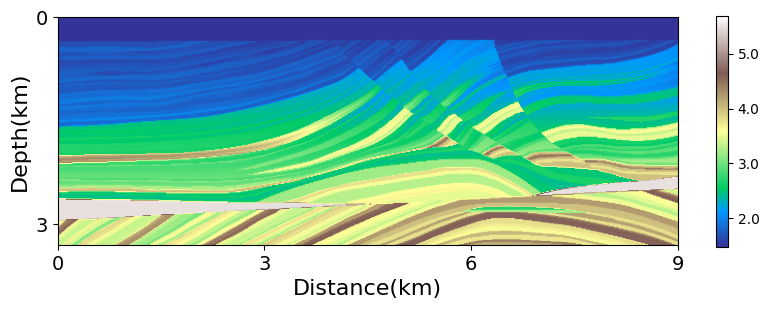

In [5]:
# Load the true model
model_true = load_velocity_model(cfg, device=device)
m_vmin, m_vmax = (
    model_true.detach().cpu().numpy().min(),
    model_true.detach().cpu().numpy().max(),
)
print(f"True model min: {m_vmin:.2f}, max: {m_vmax:.2f}")

# create mask for water layer
msk = mask(model_true, water_velocity=1.5, device=device)

plt.figure(figsize=(10, 4))
# plot true model
plt.imshow(model_true.detach().cpu().numpy(), 
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain',
           extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]]
                   )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'true-model.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

In [19]:
# generate data
data_result = np.load('./right_50particles_omar_idea.npz')
# data_result = np.load('right_50particles_idea_much_small.npz')

In [20]:
mean = data_result['updates_mean']
std  = data_result['updates_std']
model = data_result['updates']
mean.shape
model.shape

(100, 50, 132821)

In [21]:
print(m_vmin)
print(m_vmax)

1.4840147
5.694933


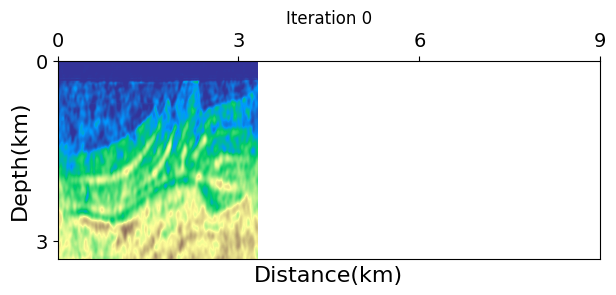

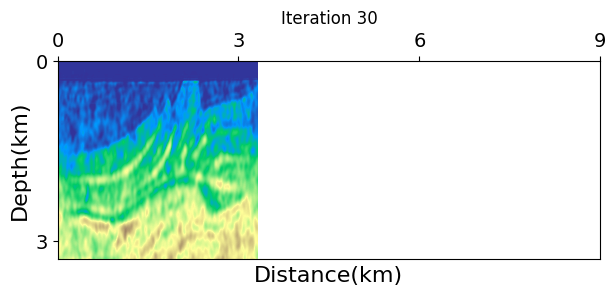

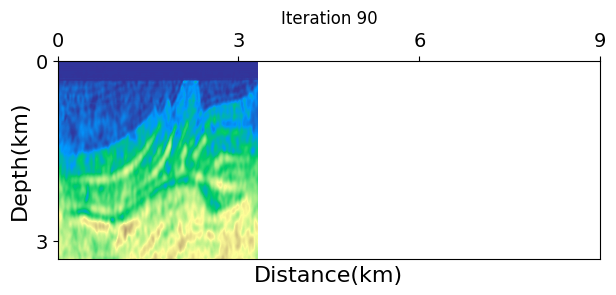

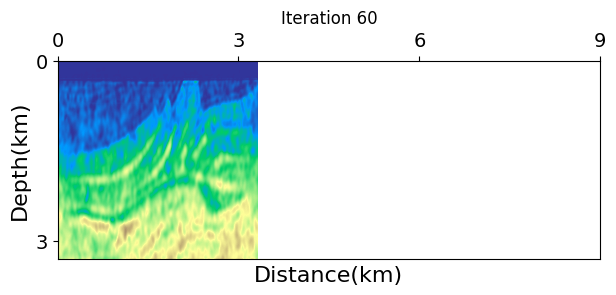

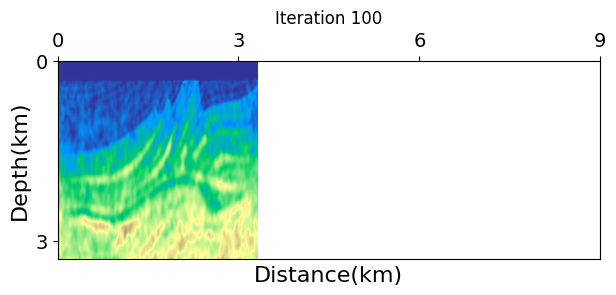

In [22]:
for i in {0,30,60,90,-1}:
    plt.figure(figsize=(7, 4))
    gr1 = model[i,40,:].reshape(cfg.params.nz, cfg.params.nx)
    # g_min, g_max = np.percentile(
    #     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
    # )
    g_min = m_vmin
    g_max = m_vmax

    plt.imshow(gr1, cmap="terrain", vmin=g_min, vmax=g_max,extent=[x[0], x[-1], z[-1], z[0]])
    i2 = i;
    if (i2==-1): i2=100
    plt.title("Iteration "+str(i2))
    #plt.colorbar(shrink=0.5)
    plt.xticks([0,200,400,600],[0,3,6,9])
    plt.yticks([0,200],[0,3])
    plt.xlabel('Distance(km)',fontsize=16)
    plt.ylabel('Depth(km)',fontsize=16)
    #colorbar = plt.colorbar(shrink=0.75)
    colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
    colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
    plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
    plt.savefig(cfg.paths.figure_path+'condition40_iter'+str(i2)+'.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

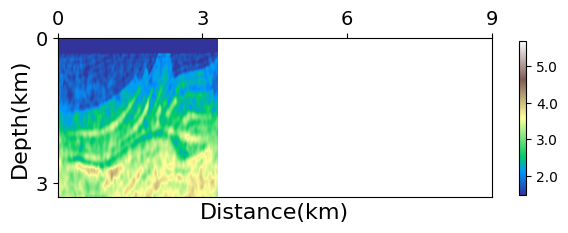

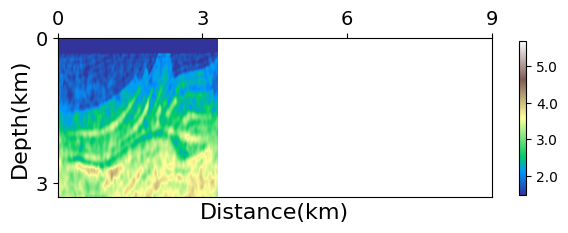

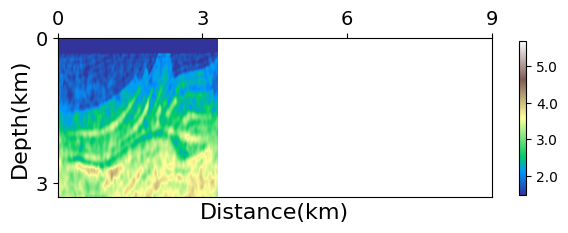

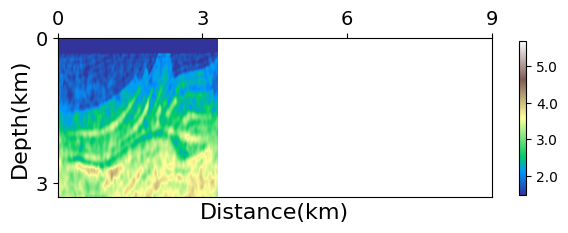

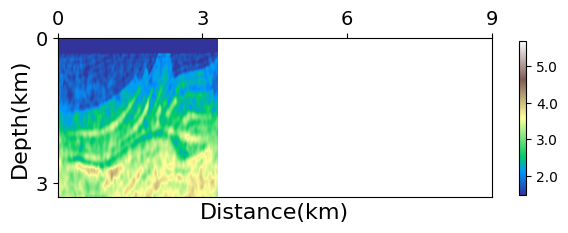

In [23]:
for i in {0,30,60,90,-1}:
        plt.figure(figsize=(7, 4))

        gr = mean[i,:].reshape(cfg.params.nz, cfg.params.nx)
        # g_min, g_max = np.percentile(
        #     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
        # )
        g_min = m_vmin
        g_max = m_vmax

        plt.imshow(gr1, cmap="terrain", vmin=g_min, vmax=g_max,extent=[x[0], x[-1], z[-1], z[0]])
        i2 = i;
        if (i2==-1): i2=100
        # plt.title("Iteration "+str(i2))
        plt.xticks([0,200,400,600],[0,3,6,9])
        plt.yticks([0,200],[0,3])
        #plt.gca().set_visible(False)
        plt.xlabel('Distance(km)',fontsize=16)
        plt.ylabel('Depth(km)',fontsize=16)
        colorbar = plt.colorbar(shrink=0.5)
        colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
        colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
        plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
        plt.savefig(cfg.paths.figure_path+'mean_iter'+str(i2)+'.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

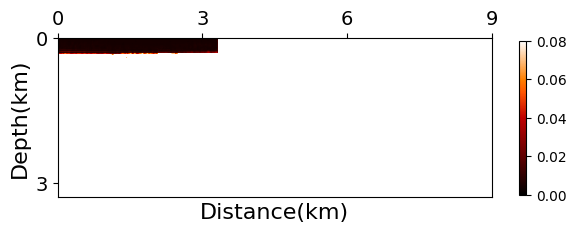

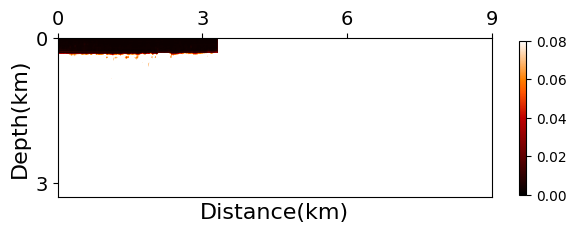

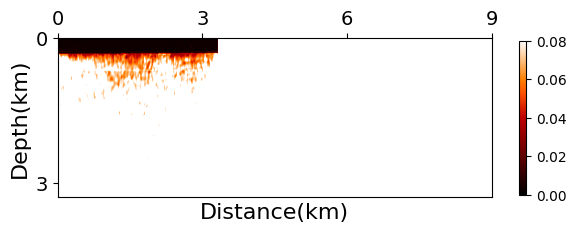

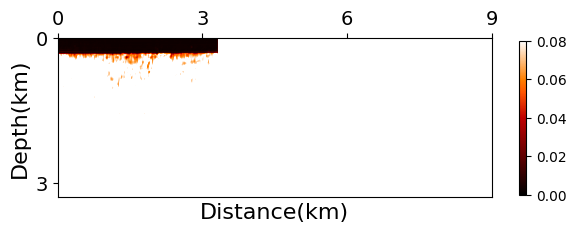

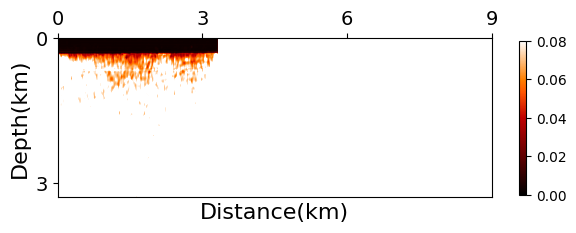

In [24]:
for i in {0,30,60,90,-1}:
        plt.figure(figsize=(7, 4))

        gr = std[i,:].reshape(cfg.params.nz, cfg.params.nx)
        # g_min, g_max = np.percentile(
        #     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
        # )
        g_min = 0
        g_max = 0.08

        plt.imshow(gr, 
                cmap="gist_heat", 
                vmin=g_min, 
                vmax=g_max,
                extent=[x[0], 
                        x[-1], 
                        z[-1], 
                        z[0]]
                )
        i2 = i;
        if (i2==-1): i2=100
        # plt.title("Iteration "+str(i2))
        plt.xticks([0,200,400,600],[0,3,6,9])
        plt.yticks([0,200],[0,3])
        # plt.gca().set_visible(False)
        plt.xlabel('Distance(km)',fontsize=16)
        plt.ylabel('Depth(km)',fontsize=16)
        colorbar = plt.colorbar(shrink=0.5)
        # colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
        # colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
        plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
        plt.savefig(cfg.paths.figure_path+'std_iter'+str(i2)+'.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

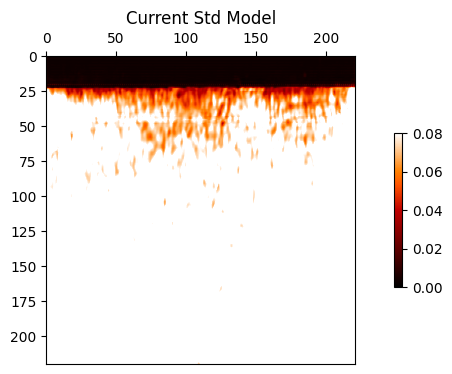

In [25]:
plt.figure(figsize=(10, 4))

gr = std[-1,:].reshape(cfg.params.nz, cfg.params.nx)
# g_min, g_max = np.percentile(
#     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
# )
g_min = 0
g_max = 0.08

plt.imshow(gr, 
            cmap="gist_heat", 
            vmin=g_min, 
            vmax=g_max,
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
            )
# plt.gca().set_visible(False)
plt.title("Current Std Model")
plt.colorbar(shrink=0.5)
plt.show()

In [26]:
cfg.params.nz

221

In [27]:
x = np.linspace(0,100,100)
print(x)

[  0.           1.01010101   2.02020202   3.03030303   4.04040404
   5.05050505   6.06060606   7.07070707   8.08080808   9.09090909
  10.1010101   11.11111111  12.12121212  13.13131313  14.14141414
  15.15151515  16.16161616  17.17171717  18.18181818  19.19191919
  20.2020202   21.21212121  22.22222222  23.23232323  24.24242424
  25.25252525  26.26262626  27.27272727  28.28282828  29.29292929
  30.3030303   31.31313131  32.32323232  33.33333333  34.34343434
  35.35353535  36.36363636  37.37373737  38.38383838  39.39393939
  40.4040404   41.41414141  42.42424242  43.43434343  44.44444444
  45.45454545  46.46464646  47.47474747  48.48484848  49.49494949
  50.50505051  51.51515152  52.52525253  53.53535354  54.54545455
  55.55555556  56.56565657  57.57575758  58.58585859  59.5959596
  60.60606061  61.61616162  62.62626263  63.63636364  64.64646465
  65.65656566  66.66666667  67.67676768  68.68686869  69.6969697
  70.70707071  71.71717172  72.72727273  73.73737374  74.74747475
  75.7575757

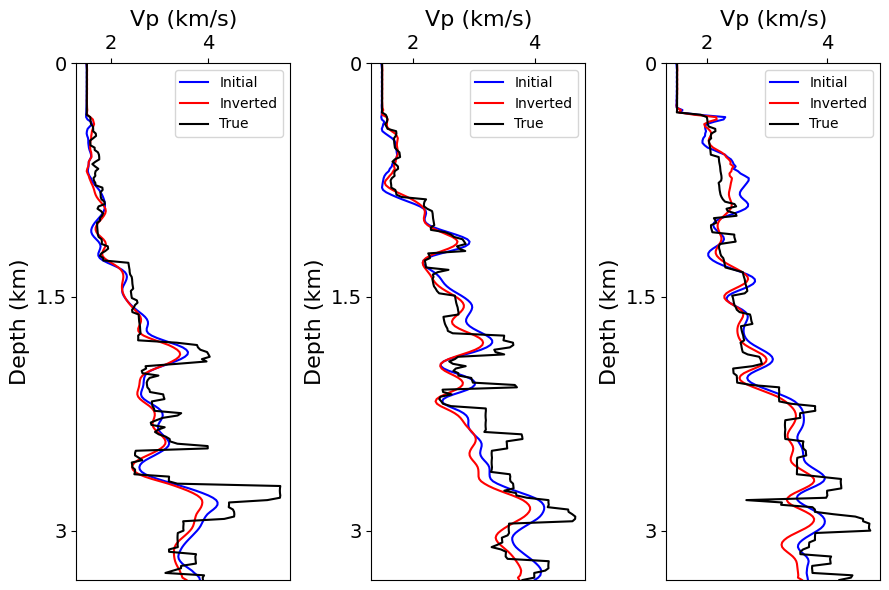

In [28]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom']=False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop']=True
fig, ax = plt.subplots(1, 3, figsize=(9, 6))
gr1 = model[0,20,:].reshape(cfg.params.nz, cfg.params.nx)
gr2 = model[-1,20,:].reshape(cfg.params.nz, cfg.params.nx)
line1 = gr1[:,200]
line2 = gr2[:,200]
line3 = model_true[:,200]

line4 = gr1[:,300]
line5 = gr2[:,300]
line6 = model_true[:,300]

line7 = gr1[:,400]
line8 = gr2[:,400]
line9 = model_true[:,400]

x = np.linspace(0,cfg.params.nz,cfg.params.nz)

ax[0].plot(line1,x,color='blue',label='Initial')
ax[0].plot(line2,x,color='red' ,label='Inverted')
ax[0].plot(line3,x,color='black',label='True')
ax[0].set_yticks([0,100,200],[0,1.5,3])
plt.gca().invert_yaxis()
ax[0].set_title('Vp (km/s)',fontsize=16)
ax[0].set_ylabel('Depth (km)',fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
ax[0].legend()
ax[0].set_ylim(221, 0) 

ax[1].plot(line4,x,color='blue',label='Initial')
ax[1].plot(line5,x,color='red' ,label='Inverted')
ax[1].plot(line6,x,color='black',label='True')
ax[1].set_yticks([0,100,200],[0,1.5,3])
plt.gca().invert_yaxis()
ax[1].set_title('Vp (km/s)',fontsize=16)
ax[1].set_ylabel('Depth (km)',fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
ax[1].legend()
ax[1].set_ylim(221, 0) 

ax[2].plot(line7,x,color='blue',label='Initial')
ax[2].plot(line8,x,color='red' ,label='Inverted')
ax[2].plot(line9,x,color='black',label='True')
ax[2].set_yticks([0,100,200],[0,1.5,3])
plt.gca().invert_yaxis()
ax[2].set_title('Vp (km/s)',fontsize=16)
ax[2].set_ylabel('Depth (km)',fontsize=16)
ax[2].tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
ax[2].legend()
ax[2].set_ylim(221, 0)  

plt.tight_layout()

plt.savefig(cfg.paths.figure_path+'FWI_result.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)
plt.show()